In [ ]:
# General Libraries
import os
import math
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Google Colab
from google.colab import drive
import gdown

# Scikit-learn (Data Processing & ML)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error

# TensorFlow & Keras (Deep Learning)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.models import load_model
import gc
import tensorflow.keras.backend as K

In [ ]:
# Download the preprocessed data
CSV_FILE_ID = "1wHcg4ESkCtWMXGdKjwKlhKk1UZghQGL1"
PICKLE_FILE_ID = "1wHcg4ESkCtWMXGdKjwKlhKk1UZghQGL1"
JSON_FILE_ID = "1wHcg4ESkCtWMXGdKjwKlhKk1UZghQGL1"

CSV_PATH = "/content/processed_data.csv"
PICKLE_PATH = "/content/processed_data.pkl"
JSON_PATH = "/content/processed_data.json"

# Try loading Pickle (Fastest format)
try:
    print("Downloading Pickle dataset...")
    gdown.download(f"https://drive.google.com/uc?id={PICKLE_FILE_ID}", PICKLE_PATH, quiet=False)
    merged_df = pd.read_pickle(PICKLE_PATH)
    print("Loaded dataset from Pickle!")
except Exception as e:
    print("⚠ Pickle file not found, trying CSV...", e)

    # Fallback to CSV (If Pickle fails)
    try:
        print("Downloading CSV dataset...")
        gdown.download(f"https://drive.google.com/uc?id={CSV_FILE_ID}", CSV_PATH, quiet=False)
        merged_df = pd.read_csv(CSV_PATH)
        print("Loaded dataset from CSV!")
    except Exception as e:
        print("ERROR: Unable to load dataset!", e)
        exit()

# Step 3: Load real-time JSON data (if available)
try:
    print("Downloading JSON dataset...")
    gdown.download(f"https://drive.google.com/uc?id={JSON_FILE_ID}", JSON_PATH, quiet=False)
    with open(JSON_PATH, "r") as json_file:
        json_data = json.load(json_file)
    print("Loaded JSON data for app integration!")
except Exception as e:
    print("⚠ JSON file not found, skipping real-time data.", e)

In [ ]:
# Train model for predicting hourly energy usage using a TPU

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # detect
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print("All TPU devices: ", tf.config.list_logical_devices('TPU'))
except ValueError:
    # Fallback to CPU or GPU if TPU not found
    strategy = tf.distribute.get_strategy()


time_steps = 8
with strategy.scope():
    model = Sequential([
        LSTM(32, activation="relu", return_sequences=True, input_shape=(time_steps, 3)),
        LSTM(16, activation="relu"),
        Dense(3)  # Predict total_hvac, total_lighting, total_mels
    ])
    model.compile(optimizer="adam", loss="mae")

# Load and Preprocess Data
merged_df["date"] = pd.to_datetime(merged_df["date"])

# Select First 3 Months Before COVID
df_3m = merged_df[(merged_df["date"] >= "2020-01-01") & (merged_df["date"] < "2020-04-01")].copy()

# Reduce Dataset Size to Prevent RAM Overflow
#df_3m = df_3m.sample(n=50000, random_state=42)  # Use only 50K rows

# Feature Engineering
df_3m["hour"] = df_3m["date"].dt.hour  # Hour of the day
df_3m["day_of_week"] = df_3m["date"].dt.dayofweek  # Monday=0, Sunday=6

# Define LSTM Time Steps
# Use past 8 hours to predict the next hour

# Convert Data to Numpy Arrays for Training
data = df_3m[["total_hvac", "total_lighting", "total_mels"]].values

X = np.array([data[i:i+time_steps] for i in range(0, len(data) - time_steps)])
y = np.array([data[i+time_steps] for i in range(0, len(data) - time_steps)])

print(f"Optimized Training Data Shape: X={X.shape}, y={y.shape}")

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert Data to Efficient TensorFlow Dataset
BATCH_SIZE = 32  # TPU prefers large batches
BUFFER_SIZE = 10000

train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_data = test_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

def prepare_tpu_dataset(X, y, batch_size=32, buffer_size=10000):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.shuffle(buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

train_data = prepare_tpu_dataset(X_train, y_train)
test_data = prepare_tpu_dataset(X_test, y_test)

# Train Model Efficiently
model.fit(train_data, epochs=5, validation_data=test_data, verbose=1)
# Save model
model.save("hourly_energy_prediction.keras")  # or .pb, or a folder with tf.saved_model
print("Model Trained and saved!")

All TPU devices:  [LogicalDevice(name='/device:TPU:0', device_type='TPU'), LogicalDevice(name='/device:TPU:1', device_type='TPU'), LogicalDevice(name='/device:TPU:2', device_type='TPU'), LogicalDevice(name='/device:TPU:3', device_type='TPU'), LogicalDevice(name='/device:TPU:4', device_type='TPU'), LogicalDevice(name='/device:TPU:5', device_type='TPU'), LogicalDevice(name='/device:TPU:6', device_type='TPU'), LogicalDevice(name='/device:TPU:7', device_type='TPU')]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Optimized Training Data Shape: X=(27654, 8, 3), y=(27654, 3)
Epoch 1/5
692/692 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.0662 - val_loss: 0.0193
Epoch 2/5
692/692 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - loss: 0.0183 - val_loss: 0.0166
Epoch 3/5
692/692 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - loss: 0.0163 - val_loss: 0.0144
Epoch 4/5
692/692 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - loss: 0.0145 - val_loss: 0.0141
Epoch 5/5
692/692 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - loss: 0.0133 - val_loss: 0.0114


173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Model Evaluated!
MAE - HVAC: 0.01
MAE - Lighting: 0.01
MAE - MELS: 0.02


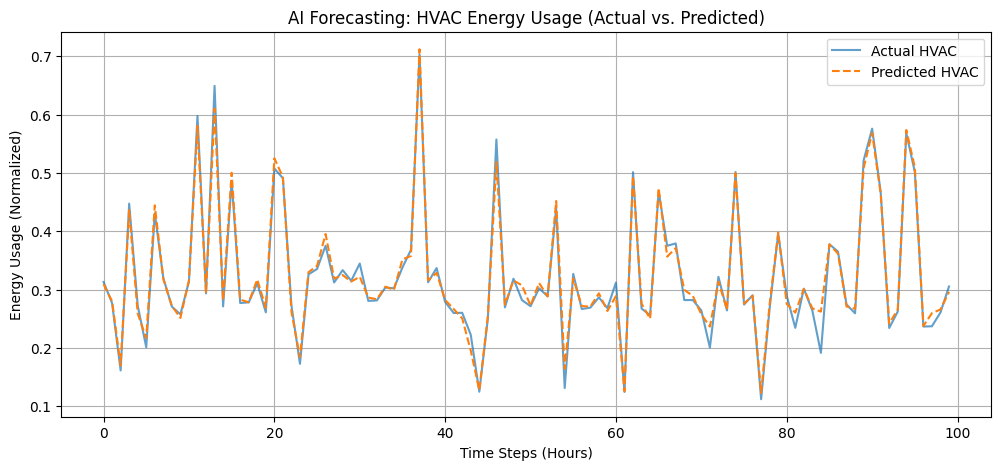

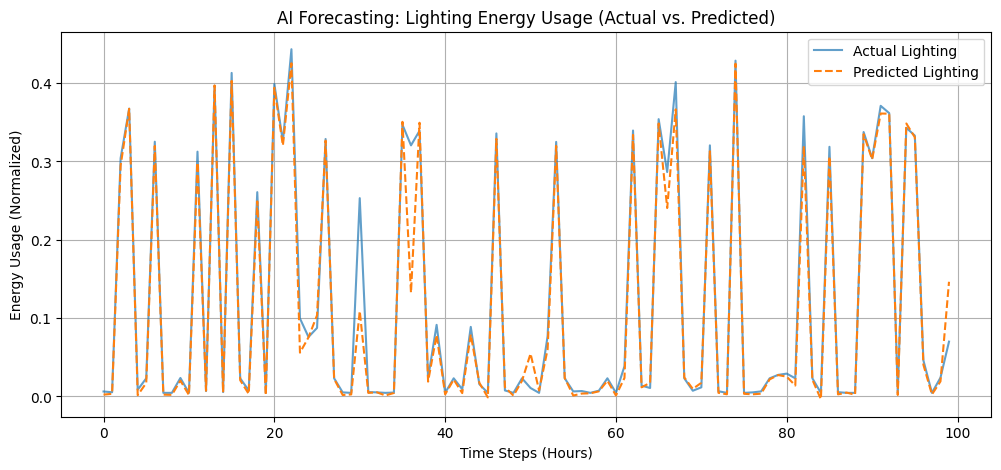

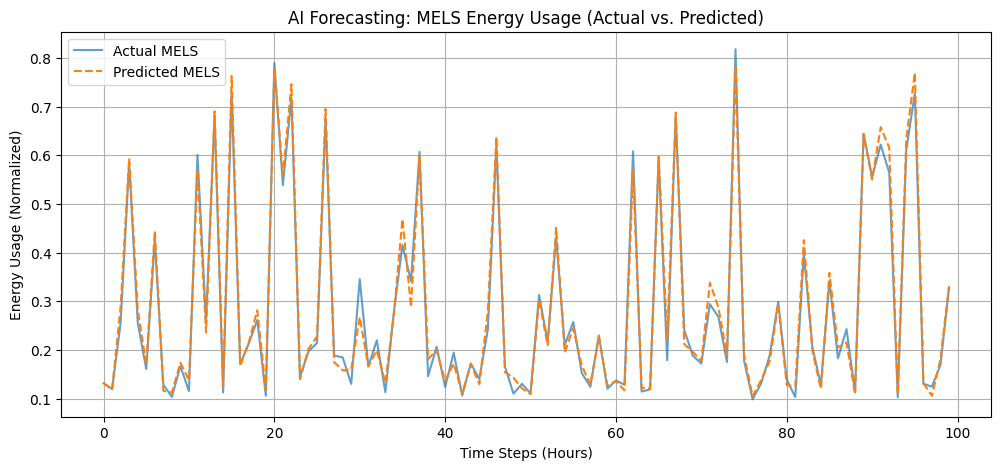

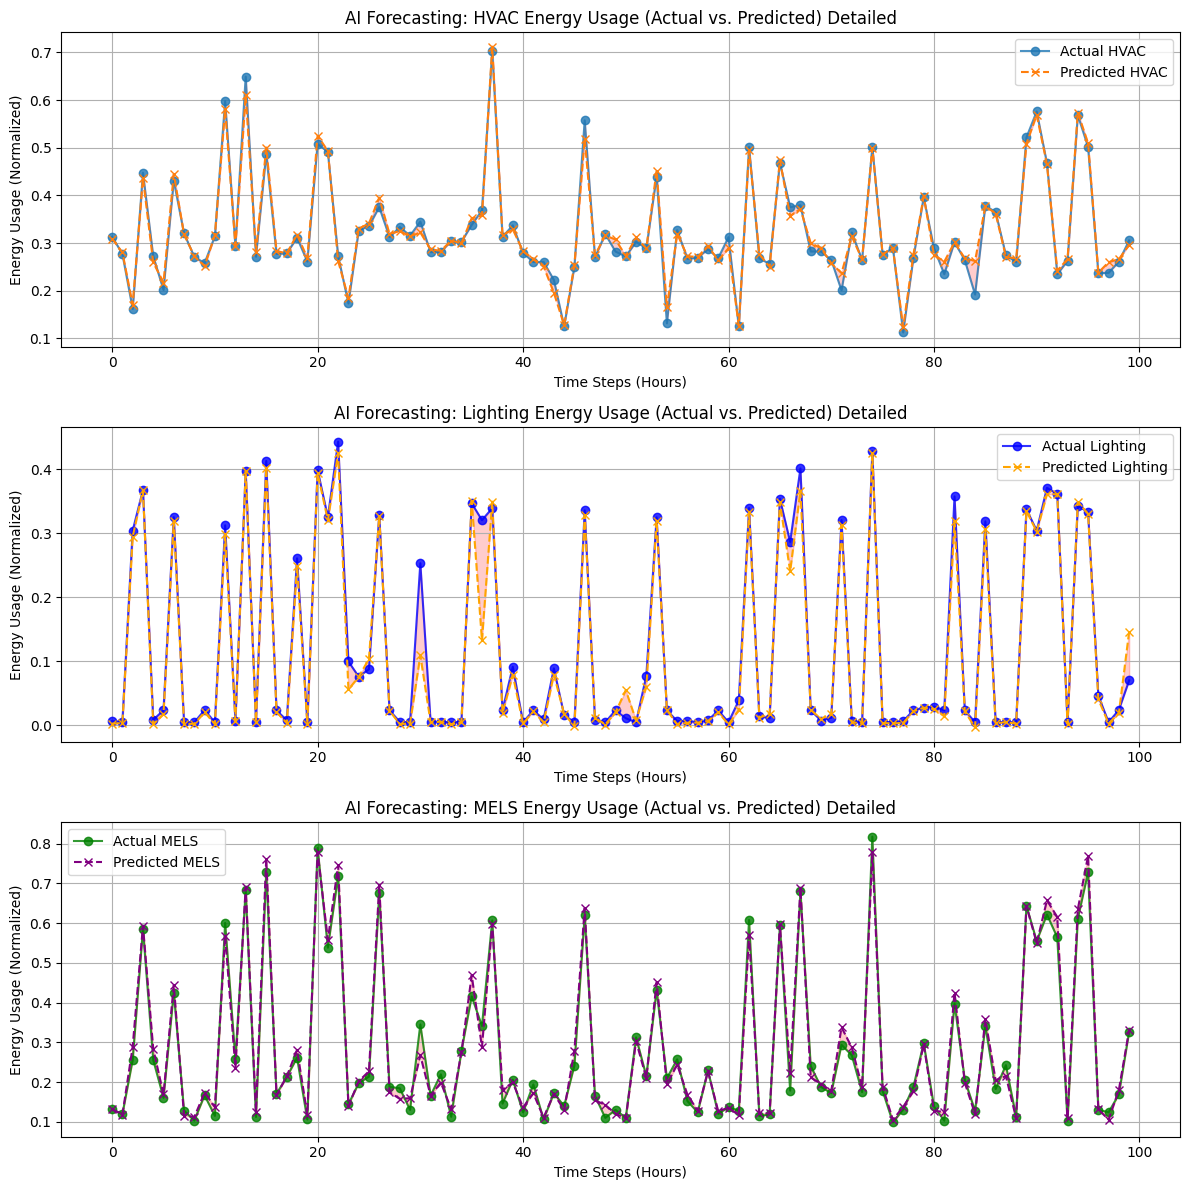

<Figure size 1200x500 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


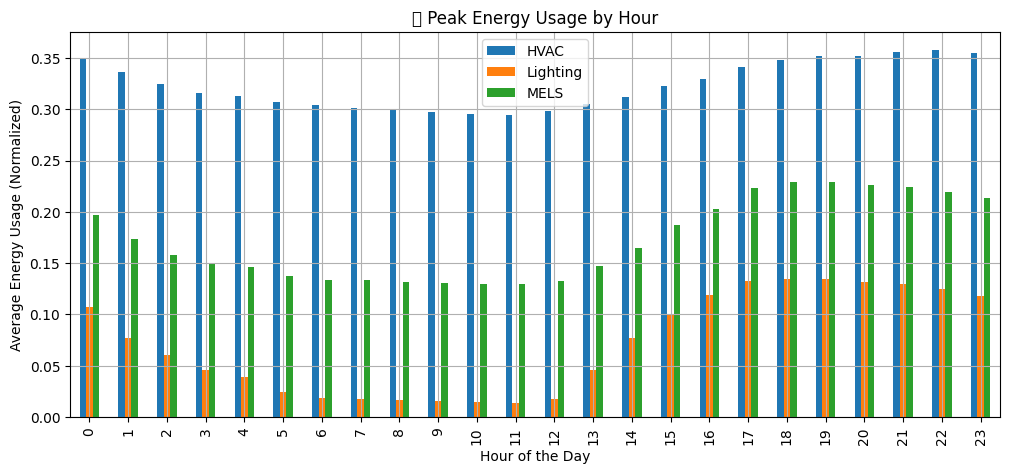

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127970 (\N{OFFICE BUILDING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


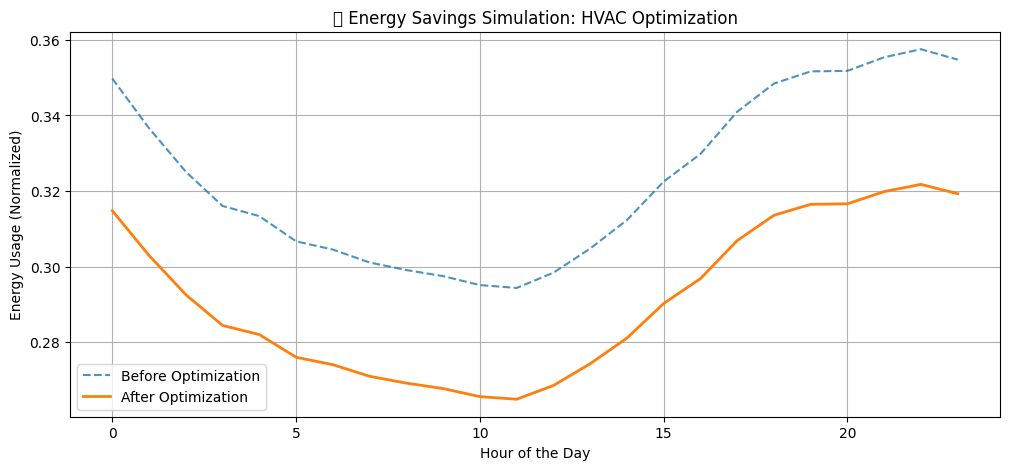

In [ ]:
# Predict & Evaluate Model
model = load_model("/content/hourly_energy_prediction.keras")

y_pred = model.predict(X_test, batch_size=32)

# Calculate Mean Absolute Error (MAE)
from sklearn.metrics import mean_absolute_error

mae_hvac = mean_absolute_error(y_test[:, 0], y_pred[:, 0])
mae_lighting = mean_absolute_error(y_test[:, 1], y_pred[:, 1])
mae_mels = mean_absolute_error(y_test[:, 2], y_pred[:, 2])

print(f"Model Evaluated!")
print(f"MAE - HVAC: {mae_hvac:.2f}")
print(f"MAE - Lighting: {mae_lighting:.2f}")
print(f"MAE - MELS: {mae_mels:.2f}")

# Plot evaluation results
# HVAC Plot
plt.figure(figsize=(12, 5))
plt.plot(y_test[:100, 0], label="Actual HVAC", alpha=0.7)
plt.plot(y_pred[:100, 0], label="Predicted HVAC", linestyle="dashed")
plt.legend()
plt.title("AI Forecasting: HVAC Energy Usage (Actual vs. Predicted)")
plt.xlabel("Time Steps (Hours)")
plt.ylabel("Energy Usage (Normalized)")
plt.grid(True)
plt.show()

# Lighting Plot
plt.figure(figsize=(12, 5))
plt.plot(y_test[:100, 1], label="Actual Lighting", alpha=0.7)
plt.plot(y_pred[:100, 1], label="Predicted Lighting", linestyle="dashed")
plt.legend()
plt.title("AI Forecasting: Lighting Energy Usage (Actual vs. Predicted)")
plt.xlabel("Time Steps (Hours)")
plt.ylabel("Energy Usage (Normalized)")
plt.grid(True)
plt.show()

# MELS Plot
plt.figure(figsize=(12, 5))
plt.plot(y_test[:100, 2], label="Actual MELS", alpha=0.7)
plt.plot(y_pred[:100, 2], label="Predicted MELS", linestyle="dashed")
plt.legend()
plt.title("AI Forecasting: MELS Energy Usage (Actual vs. Predicted)")
plt.xlabel("Time Steps (Hours)")
plt.ylabel("Energy Usage (Normalized)")
plt.grid(True)
plt.show()

# Compute absolute errors
error_hvac = np.abs(y_test[:100, 0] - y_pred[:100, 0])
error_lighting = np.abs(y_test[:100, 1] - y_pred[:100, 1])
error_mels = np.abs(y_test[:100, 2] - y_pred[:100, 2])

fig, axes = plt.subplots(3, 1, figsize=(12, 12))

# HVAC Plot Detailed
axes[0].plot(y_test[:100, 0], label="Actual HVAC", alpha=0.8, marker="o")
axes[0].plot(y_pred[:100, 0], label="Predicted HVAC", linestyle="dashed", marker="x")
axes[0].fill_between(range(100), y_test[:100, 0], y_pred[:100, 0], color="red", alpha=0.2)  # Shade error
axes[0].legend()
axes[0].set_title("AI Forecasting: HVAC Energy Usage (Actual vs. Predicted) Detailed")
axes[0].set_ylabel("Energy Usage (Normalized)")
axes[0].set_xlabel("Time Steps (Hours)")
axes[0].grid(True)

# Lighting Plot Detailed
axes[1].plot(y_test[:100, 1], label="Actual Lighting", alpha=0.8, marker="o", color="blue")
axes[1].plot(y_pred[:100, 1], label="Predicted Lighting", linestyle="dashed", marker="x", color="orange")
axes[1].fill_between(range(100), y_test[:100, 1], y_pred[:100, 1], color="red", alpha=0.2)
axes[1].legend()
axes[1].set_title("AI Forecasting: Lighting Energy Usage (Actual vs. Predicted) Detailed")
axes[1].set_ylabel("Energy Usage (Normalized)")
axes[1].set_xlabel("Time Steps (Hours)")
axes[1].grid(True)

# MELS Plot Detailed
axes[2].plot(y_test[:100, 2], label="Actual MELS", alpha=0.8, marker="o", color="green")
axes[2].plot(y_pred[:100, 2], label="Predicted MELS", linestyle="dashed", marker="x", color="purple")
axes[2].fill_between(range(100), y_test[:100, 2], y_pred[:100, 2], color="red", alpha=0.2)
axes[2].legend()
axes[2].set_title("AI Forecasting: MELS Energy Usage (Actual vs. Predicted) Detailed")
axes[2].set_ylabel("Energy Usage (Normalized)")
axes[2].set_xlabel("Time Steps (Hours)")
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Show some possible energy savings insights

plt.figure(figsize=(12, 5))
hourly_avg = merged_df.groupby("hour")[["total_hvac", "total_lighting", "total_mels"]].mean()
hourly_avg.plot(kind="bar", figsize=(12, 5))
plt.title("🔍 Peak Energy Usage by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Average Energy Usage (Normalized)")
plt.legend(["HVAC", "Lighting", "MELS"])
plt.grid(True)
plt.show()

# Simulated optimized energy use: Reduce peak by 10%
optimized_usage = hourly_avg * 0.90  # Assume 10% energy savings

plt.figure(figsize=(12, 5))
plt.plot(hourly_avg["total_hvac"], label="Before Optimization", linestyle="dashed", alpha=0.8)
plt.plot(optimized_usage["total_hvac"], label="After Optimization", linewidth=2)
plt.title("🏢 Energy Savings Simulation: HVAC Optimization")
plt.xlabel("Hour of the Day")
plt.ylabel("Energy Usage (Normalized)")
plt.legend()
plt.grid(True)
plt.show()